In [35]:
# Simulation for a colloidal particle in water at room temperature.
import math
import numpy as np 
import matplotlib.pyplot as plt

R = 1e-6  # Radius of the Brownian particle [m].
eta = 1e-3  # Viscosity of the medium.
gamma = 6 * np.pi * R * eta  # Drag coefficient of the medium. 
kB = 1.380e-23  # Boltzmann constant [J/K].
T = 300  # Temperature [K].
kBT = kB*T  # kB*T at room temperature [J].
D = kBT / gamma  # Diffusion constant [m^2 / s].

In [44]:
import math
import numpy as np 
import matplotlib.pyplot as plt

def tMSD_2d(x,y,L):
    """
    Function to calculate the tMSD.
    
    Parameters
    ==========
    x : Trajectory (x component).
    y : Trajectory (x component).
    L : Indicates the maximum delay (L * dt) considered.
    """

    tmsd = np.zeros(L)
    
    nelem = np.size(x)

    for n in range(L):
        Nmax = nelem - n
        dx = x[n:nelem] -  x[0: Nmax]
        dy = y[n:nelem] -  y[0: Nmax]
        tmsd[n] += np.mean((dx ** 2) + (dy**2))

    return tmsd

In [37]:
def eMSD_2d(x, y):
    """
    Compute ensemble-averaged MSD in 2D, relative to the starting point.

    Parameters
    ----------
    x : ndarray, shape (N_traj, N_steps)
        Trajectories (x component).
    y : ndarray, shape (N_traj, N_steps)
        Trajectories (y component).

    Returns
    -------
    emsd : ndarray, shape (N_steps,)
        Ensemble-averaged MSD vs. time, measured from the initial position.
    """
    N_traj, N_steps = x.shape

    # subtract initial position using broadcasting
    dx = x - x[:, [0]]   # shape (N_traj, N_steps)
    dy = y - y[:, [0]]   # shape (N_traj, N_steps)

    # squared displacement
    disp2 = dx**2 + dy**2

    # average over trajectories
    emsd = np.mean(disp2, axis=0)

    return emsd


The code for the harmonic trap

In [68]:
import numpy as np
k = 1e-6  # Trapping stiffness [N/m].

dt = 2e-3  # Time step [s]. For viscous simulation.

# Coefficients for the finite difference solution.
c_noise = np.sqrt(2 * D * dt)
c_trap = k / gamma * dt

# Simulation for tMSD. Long trajectory with 1e+6 points.
N_steps_t = int(3e+4) # Will give 60s of simulation.
#N_steps_t = int(18e+4) # Will give 360s of simulation.

duration_t = N_steps_t * dt  # Total time [s].

# Simulation for eMSD. 1e+3 trajectories with 1e+3 points each.
N_steps_e = int(3e+4) # Will give 60s of simulation.
#N_steps_e = int(18e+4) # Will give 360s of simulation.

duration_e = N_steps_e * dt  # Total time [s].
N_traj = 1000 # N_e - ensemble trajectories.

x0 = 0  # Initial position [m].
y0 = 0  # Initial position [m].

# Generate long trajectory for time average.

x_t = np.zeros(N_steps_t)
y_t = np.zeros(N_steps_t)
rn_t_x = np.random.normal(0, 1, N_steps_t)
rn_t_y = np.random.normal(0, 1, N_steps_t)

x_t[0] = x0

for n in range(N_steps_t - 1):
    x_t[n + 1] = x_t[n] - c_trap * x_t[n] + c_noise * rn_t_x[n]

y_t[0] = y0

for n in range(N_steps_t - 1):
    y_t[n + 1] = y_t[n] - c_trap * y_t[n] + c_noise * rn_t_y[n]

# Build the time dependence.
t_t = dt * np.arange(N_steps_t) # Should I use t_t for later for plotting?

# Calculate tMSD
tmsd = tMSD_2d(x_t,y_t, L=N_steps_e)  # Note: L=N_steps_e.

# Define the time dependence for tMSD (and later eMSD)
t_delay = dt * np.arange(N_steps_e)

Plot time dependence of x (t), y(t), tMSD

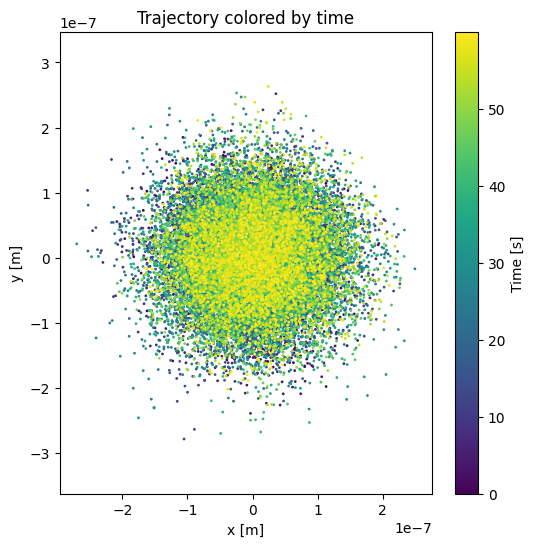

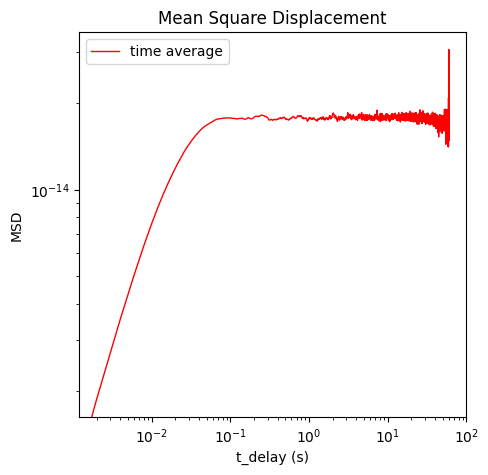

In [69]:
plt.figure(figsize=(6,6))
plt.scatter(x_t, y_t, c=t_t, cmap='viridis', s=1)
plt.title('Trajectory colored by time')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.colorbar(label='Time [s]')
plt.show()


plt.figure(figsize=(5,5))
plt.loglog(t_delay, tmsd, '-', color='r', linewidth=1, 
         label='time average')
plt.legend()
plt.title('Mean Square Displacement')
plt.xlabel('t_delay (s)')
plt.ylabel('MSD')
plt.show()

Now generate ensemble trajectories by allowing thermalization. Let the system thermalize for a time t0

In [70]:
import numpy as np

# Initial positions
x0 = 0.0  # [m]
y0 = 0.0  # [m]
tau = gamma / k  # Relaxation time [s].
t0 = 5000* tau
# Thermalization steps
N_steps_thermalization = 1000
#math.ceil(t0) # rounded up to nearest integer
print(N_steps_thermalization)

# Allocate arrays for ensemble trajectories
x_e = np.zeros((N_traj, N_steps_e))
y_e = np.zeros((N_traj, N_steps_e))

# Random numbers for ensemble trajectories
rn_e_x = np.random.normal(0, 1, size=(N_traj, N_steps_e))
rn_e_y = np.random.normal(0, 1, size=(N_traj, N_steps_e))

for i in range(N_traj):
    # --- Thermalization cycle for x ---
    x = x0
    rn_therm_x = np.random.normal(0, 1, N_steps_thermalization)
    for n in range(N_steps_thermalization - 1):
        x = x - c_trap * x + c_noise * rn_therm_x[n]

    # --- Thermalization cycle for y ---
    y = y0
    rn_therm_y = np.random.normal(0, 1, N_steps_thermalization)
    for n in range(N_steps_thermalization - 1):
        y = y - c_trap * y + c_noise * rn_therm_y[n]

    # Start from thermalized positions
    x_e[i, 0] = x
    y_e[i, 0] = y

    # Build trajectory for x and y
    for n in range(N_steps_e - 1):
        x_e[i, n + 1] = x_e[i, n] - c_trap * x_e[i, n] + c_noise * rn_e_x[i, n]
        y_e[i, n + 1] = y_e[i, n] - c_trap * y_e[i, n] + c_noise * rn_e_y[i, n]

# Build the time dependence
t_e = dt * np.arange(N_steps_e)

# Calculate 2D ensemble MSD
emsd_therm_2d = eMSD_2d(x_e, y_e)


1000


Plot time dependence and eMSD for the thermalized trajectories.

In [ ]:
plt.figure()
for i in range(N_traj):
    plt.plot(x_e[i, :], y_e[i, :])
plt.title('Trajectories - Ensemble')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(5,5))
plt.loglog(t_delay, emsd_therm_2d, '-', color='g', linewidth=1, 
         label='ensemble average')
plt.legend()
plt.title('Mean Square Displacement')
plt.xlabel('t_delay (s)')
plt.ylabel('MSD')
plt.show()

Plot and compare tMSD and eMSD for thermalized eMSD

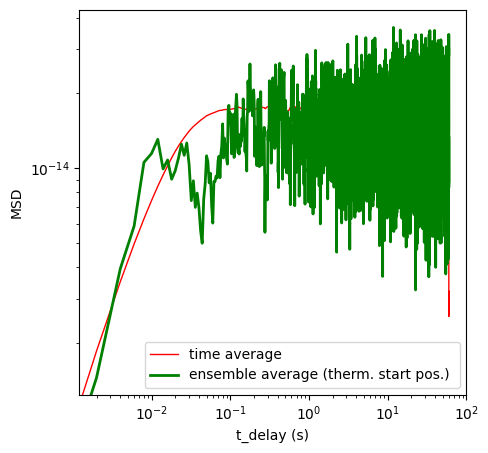

In [66]:
plt.figure(figsize=(5,5))
plt.loglog(t_delay, tmsd, '-', color='r', linewidth=1, 
         label='time average')
plt.loglog(t_delay, emsd_therm_2d, '-', color='g', linewidth=2, 
         label='ensemble average (therm. start pos.) ')
plt.legend()
plt.xlabel('t_delay (s)')
plt.ylabel('MSD')
plt.show()